### Part 1: Binary classification with imbalanced medical data

In Part 1, we will be working with the “mammography” standard binary classification dataset (mam.csv), sometimes called “Woods Mammography“. The dataset is credited to Kevin Woods, et al. and the 1993 paper titled “Comparative Evaluation Of Pattern Recognition Techniques For Detection Of Microcalcifications In Mammography.” (Can be found here: https://www.worldscientific.com/doi/abs/10.1142/S0218001493000698). The Mammography dataset is a widely used standard machine learning dataset, used to explore and demonstrate many techniques designed specifically for imbalanced classification. 

Our problem is detecting breast cancer from radiological scans. More specifically, these scans are looking for clusters of microcalcifications which appear bright on a mammogram. There are two classes and the goal is to distinguish between microcalcifications and non-microcalcifications using the features for a given segmented object. For this problem, finding as many positives as we can is the goal and getting a false positive is not nearly as bad as a false negative. Thus, we will focus on the recall score of our models.

**Non-microcalcifications:** negative case, or majority class.\
**Microcalcifications:** positive case, or minority class.\

1. What percentage of the data are positive cases? 

2. Let's compare some imbalance techniques and do some hyperparameter tuning. This dataset is small enough that GridSearchCV should not take too long (depending on your grid of hyperparameters).  In GridSearchCV, set scoring='recall' . Define a dictionary that contains the values you want to try for 'max_depth', 'min_samples_split', and 'min_samples_leaf'. Complete a grid search to test the following techniques for dealing with imbalanced data:
    1. Do nothing
    2. Use balanced class weights when you define your decision tree (Use class_weight='balanced' in DecisionTreeClassifier() ). 
    3. Use random oversampling on your training data.
    4. Use random undersampling on your training data.
    5. Use SMOTE on your training data.
3. For each technique, use the best estimator from the grid search to predict values for the test set and the training set. Compute the recall score and the F1 score for the training set and the test set (We will look at the F1 score for comparison). Show the confusion matrix for the test set.
4. Write a paragraph describing your results. Which imbalance technique gave the best recall scores on the test set? What is the F1 score on the test set for this model? Out of the models we trained, is this the model you would use for this problem?  Are the best decision tree parameters similar when using the different imbalance techniques?

In [2]:
import pandas as pd  
import numpy as np  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from matplotlib import pyplot as plt      
import seaborn as sns    
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score, f1_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [3]:
cancer = pd.read_csv('mam.csv')

In [4]:
cancer

,attr1,attr2,attr3,attr4,attr5,attr6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0
...,...,...,...,...,...,...,...
11178,-0.250012,-0.377300,-0.321142,1.269157,3.652984,1.092791,1
11179,0.281343,-0.417112,-0.366224,0.851010,2.789649,1.345700,1
11180,1.204988,1.763724,-0.501468,1.562408,6.489072,0.931294,1
11181,0.736644,-0.222474,-0.050653,1.509665,0.539269,1.315229,1


In [5]:
cancer.value_counts('class')

class
0    10923
1      260
Name: count, dtype: int64

In [32]:
#1
print('Percentage of Positive Cases:', f'{round((260/11183)*100, 3)}%')

Percentage of Positive Cases: 2.325%


2. Let's compare some imbalance techniques and do some hyperparameter tuning. This dataset is small enough that GridSearchCV should not take too long (depending on your grid of hyperparameters).  In GridSearchCV, set scoring='recall' . Define a dictionary that contains the values you want to try for 'max_depth', 'min_samples_split', and 'min_samples_leaf'. Complete a grid search to test the following techniques for dealing with imbalanced data:
    1. Do nothing
    2. Use balanced class weights when you define your decision tree (Use class_weight='balanced' in DecisionTreeClassifier() ). 
    3. Use random oversampling on your training data.
    4. Use random undersampling on your training data.
    5. Use SMOTE on your training data.

In [33]:
#2
X = cancer.drop(columns=['class'])
y = cancer['class']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=290)

Do Nothing Results:
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2}
Recall (Train): 0.7868852459016393
Recall (Test): 0.6493506493506493
F1 Score (Train): 0.8753799392097265
F1 Score (Test): 0.6756756756756757

Confusion Matrix: [[3257   21]
 [  27   50]]



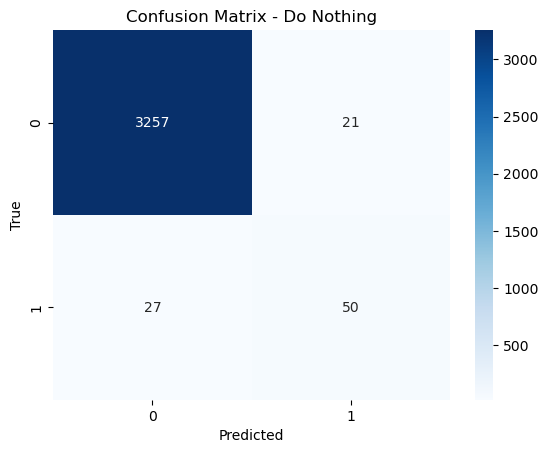

DecisionTreeClassifier(max_depth=12, min_samples_leaf=2, random_state=290)

In [10]:
# rest of 2 and 3
'''
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

'''
param_grid = {
    'max_depth': [2, 3, 4, 6, 8, 10, 12, 14, None],
    'min_samples_split': range(2, 25, 2),
    'min_samples_leaf': range(2, 25, 2)
}


def train_and_evaluate(model, X_train, y_train, X_test, y_test, title):
    gs = GridSearchCV(model, param_grid, scoring='recall', cv=5)
    gs.fit(X_train, y_train)
    
    best_model = gs.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    

    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)

    cm_test = confusion_matrix(y_test, y_test_pred)
    
    print(f"{title} Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Recall (Train): {recall_train:}")
    print(f"Recall (Test): {recall_test:}")
    print(f"F1 Score (Train): {f1_train:}")
    print(f"F1 Score (Test): {f1_test:}\n")
    print(f"Confusion Matrix: {cm_test:}\n")
    
    fig, ax = plt.subplots()
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()
    
    return best_model


dt = DecisionTreeClassifier(random_state=290)
dt_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=290)

train_and_evaluate(dt, X_train, y_train, X_test, y_test, "Do Nothing")

Class Weight Balancing Results:
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Recall (Train): 0.8852459016393442
Recall (Test): 0.8831168831168831
F1 Score (Train): 0.2555205047318612
F1 Score (Test): 0.2546816479400749

Confusion Matrix: [[2889  389]
 [   9   68]]



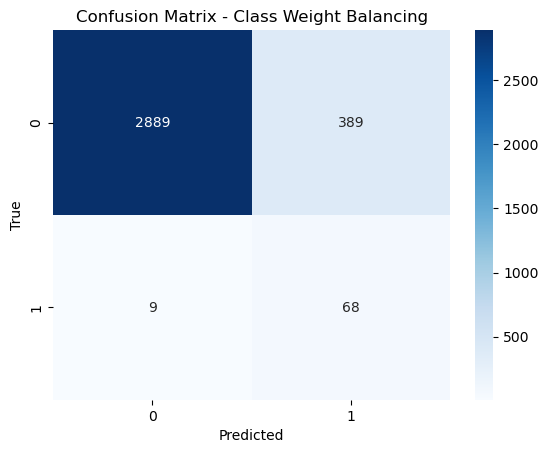

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=2,
                       random_state=290)

In [11]:
train_and_evaluate(dt_balanced, X_train, y_train, X_test, y_test, "Class Weight Balancing")

Random Oversampling Results:
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2}
Recall (Train): 0.9773708306082407
Recall (Test): 0.7402597402597403
F1 Score (Train): 0.9849723174268389
F1 Score (Test): 0.6

Confusion Matrix: [[3222   56]
 [  20   57]]



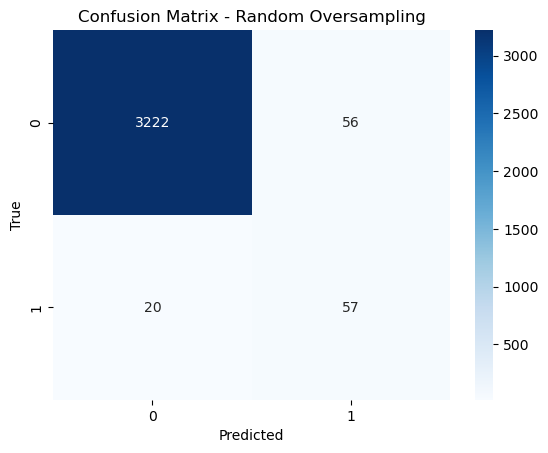

DecisionTreeClassifier(max_depth=12, min_samples_leaf=2, random_state=290)

In [12]:
ros = RandomOverSampler(random_state=290)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
train_and_evaluate(dt, X_train_ros, y_train_ros, X_test, y_test, "Random Oversampling")

Random Undersampling Results:
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Recall (Train): 0.819672131147541
Recall (Test): 0.8311688311688312
F1 Score (Train): 0.8797653958944281
F1 Score (Test): 0.29836829836829837

Confusion Matrix: [[2990  288]
 [  13   64]]



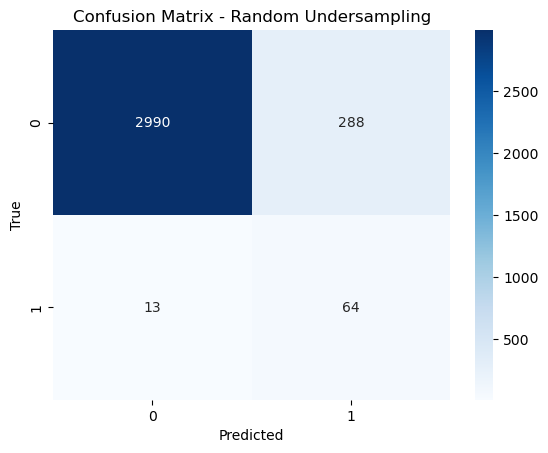

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=290)

In [13]:
rus = RandomUnderSampler(random_state=290)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
train_and_evaluate(dt, X_train_rus, y_train_rus, X_test, y_test, "Random Undersampling")

SMOTE Results:
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 24}
Recall (Train): 0.9712230215827338
Recall (Test): 0.8051948051948052
F1 Score (Train): 0.9741537654159014
F1 Score (Test): 0.5040650406504065

Confusion Matrix: [[3171  107]
 [  15   62]]



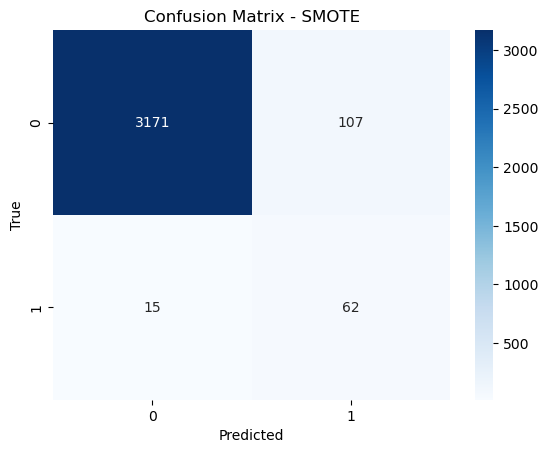

DecisionTreeClassifier(max_depth=12, min_samples_leaf=6, min_samples_split=24,
                       random_state=290)

In [14]:
smote = SMOTE(random_state=290)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
train_and_evaluate(dt, X_train_smote, y_train_smote, X_test, y_test, "SMOTE")

Number 4 Analysis: 

Recall Best to Worst:
1. Balance: 0.883
2. Under: 0.831
3. SMOTE: 0.805
4. Over: 0.740
5. Nothing: 0.649

F1 Best to Worst:
1. Nothing: 0.676
2. Over: 0.6
3. SMOTE: 0.504
4. Under: 0.298
5. Balance: 0.255

The class weight balancing gave the best recall, but it has the worst F1 score at about 25.5%; I would not recommend using this model just because of how low the F1 score is, it identified the most positive cases but also had a high false positive rate. To me, in order to have the best balance performance between Recall and F1, I would go with the SMOTE model. For the decision tree parameters, all of them except SMOTE had min_samples_split at 2 and min_sample_leafs at 2, but SMOTE was at 24 and 6 respectively. For the max_depth, class weight balancing and random undersampling did best at depth 3 versus the other 3 did best at depth 12. So overall, I would say that the parameters with best results are fairly similar. 


# Part 2: Binary classification with imbalanced fraud data

In Part 2, we will be working with data from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset contains transactions made by credit cards in September 2013 by European cardholders. From the Kaggle description:

*It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.*

We will use these unknown features to predict whether the transaction is fraudulent, indicated by the column 'Class' (0 = not fraudulent, 1 = fraudulent).

1. What percentage of the data are positive cases? 

2. and 3. Do a comparison like we did in Part 1, but you probably want to use RandomizedSearchCV instead of GridSearchCV. Report the recall and F1 scores for the training and test sets and show the confusion matrix for the test set for each data imbalance technique.

4. Write a paragraph describing your results. Which technique gave the best F1 results on the test set? What is the recall score on the test set for this model?  Which imbalance technique gave the best recall score in Part 2? Why might this model be a good one to use for fraud detection?

In [22]:
credit = pd.read_csv('creditcard.csv')

In [23]:
credit

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [24]:
credit[credit['Class']==1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [25]:
#1
print('Percent of Positive Cases:', f'{round((492/284807)*100, 2)}%' )

Percent of Positive Cases: 0.17%


In [34]:
#2
X = credit.drop(columns=['Class'])
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=290)

Do Nothing Results:
Best Parameters: {'min_samples_split': 22, 'min_samples_leaf': 8, 'max_depth': 4}
Recall (Train): 0.7941176470588235
Recall (Test): 0.8355263157894737
F1 Score (Train): 0.8206686930091185
F1 Score (Test): 0.8355263157894737



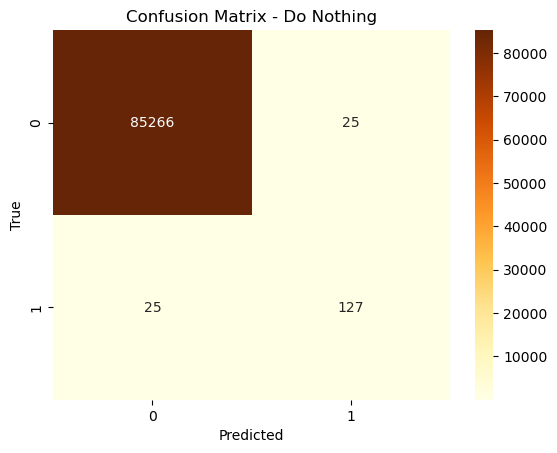

DecisionTreeClassifier(max_depth=4, min_samples_leaf=8, min_samples_split=22,
                       random_state=290)

In [27]:
# rest of 2 and 3
param_grid = {
    'max_depth': [2, 3, 4, 6, 8, 10, 12, 14, None],
    'min_samples_split': range(2, 25, 2),
    'min_samples_leaf': range(2, 25, 2)
}

def evaluate(model, X_train, y_train, X_test, y_test, title):
    rs = RandomizedSearchCV(model, param_grid, scoring='recall', cv=5)
    rs.fit(X_train, y_train)
    
    best_model = rs.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    

    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)

    cm_test = confusion_matrix(y_test, y_test_pred)
    
    print(f"{title} Results:")
    print(f"Best Parameters: {rs.best_params_}")
    print(f"Recall (Train): {recall_train:}")
    print(f"Recall (Test): {recall_test:}")
    print(f"F1 Score (Train): {f1_train:}")
    print(f"F1 Score (Test): {f1_test:}\n")
    
    fig, ax = plt.subplots()
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='YlOrBr')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()
    
    return best_model


dt = DecisionTreeClassifier(random_state=290)
dt_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=290)

evaluate(dt, X_train, y_train, X_test, y_test, "Do Nothing")

Class Weight Balancing Results:
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 2}
Recall (Train): 0.9382352941176471
Recall (Test): 0.9276315789473685
F1 Score (Train): 0.03197353914002205
F1 Score (Test): 0.03310247681652776



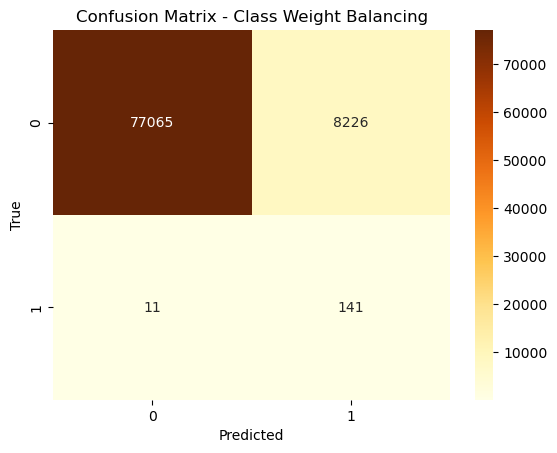

DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       min_samples_split=10, random_state=290)

In [28]:
evaluate(dt_balanced, X_train, y_train, X_test, y_test, "Class Weight Balancing")

Random Oversampling Results:
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 14}
Recall (Train): 1.0
Recall (Test): 0.8355263157894737
F1 Score (Train): 0.9994300420563681
F1 Score (Test): 0.6105769230769231



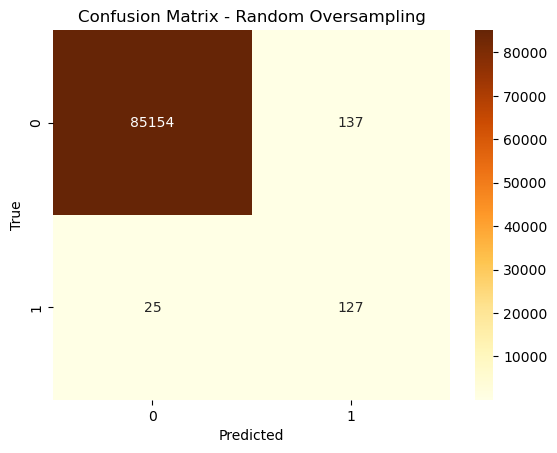

DecisionTreeClassifier(max_depth=14, min_samples_leaf=8, min_samples_split=10,
                       random_state=290)

In [29]:
ros = RandomOverSampler(random_state=290)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
evaluate(dt, X_train_ros, y_train_ros, X_test, y_test, "Random Oversampling")

Random Undersampling Results:
Best Parameters: {'min_samples_split': 8, 'min_samples_leaf': 14, 'max_depth': 4}
Recall (Train): 0.95
Recall (Test): 0.9342105263157895
F1 Score (Train): 0.936231884057971
F1 Score (Test): 0.031318923687692984



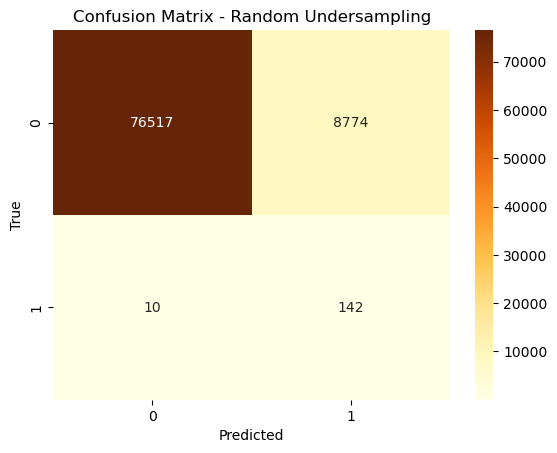

DecisionTreeClassifier(max_depth=4, min_samples_leaf=14, min_samples_split=8,
                       random_state=290)

In [30]:
rus = RandomUnderSampler(random_state=290)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
evaluate(dt, X_train_rus, y_train_rus, X_test, y_test, "Random Undersampling")

SMOTE Results:
Best Parameters: {'min_samples_split': 6, 'min_samples_leaf': 14, 'max_depth': None}
Recall (Train): 0.9983368839938902
Recall (Test): 0.875
F1 Score (Train): 0.998108700730147
F1 Score (Test): 0.48363636363636364



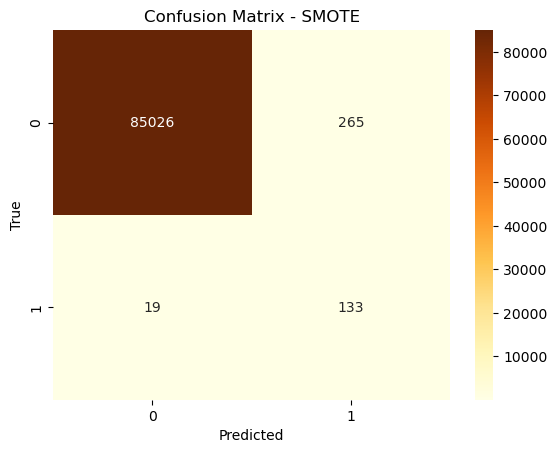

DecisionTreeClassifier(min_samples_leaf=14, min_samples_split=6,
                       random_state=290)

In [31]:
smote = SMOTE(random_state=290)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
evaluate(dt, X_train_smote, y_train_smote, X_test, y_test, "SMOTE")

Recalls Best to Worst:
1. Under: 0.934
2. Balance: 0.928
3. SMOTE: 0.875
4. Over: 0.836
5. Nothing: 0.835

F1 Scores Best to Worst:
1. Nothing: 0.835
2. Over: 0.611
3. SMOTE: 0.483
4. Balance: 0.033
5. Under: 0.031



#4: 
Write a paragraph describing your results. Which technique gave the best F1 results on the test set? What is the recall score on the test set for this model? Which imbalance technique gave the best recall score in Part 2? Why might this model be a good one to use for fraud detection?

The baseline got the best F1 score but the worst Recall. The random undersampling gave the best recall score but it had the worst F1 score. The model that I think would work best in fraud detection based on the results that I got is the Random Oversampling oe SMOTE becuase they have the highest average between the recall and F1, basically the best balanced percentages. If you just want purely the one that had the best recall then it would be the random undersampling, but because its F1 score was so low(0.031) then I do not think that it would be worth it to use it. For the decision tree parameters, these results were much more varied than part 1, the only similarities were for min_samples_leaf. 